# 1.0 Import dependencis

In [1]:
#Import dependencis

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as image


# 2.0 Load data

In [2]:
## Load fashion_mnist data set

data = tfds.load('fashion_mnist',split='train')

#Identify the components of the data set

data.as_numpy_iterator().next().keys()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteETNJC5/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteETNJC5/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


dict_keys(['image', 'label'])

# 3.0 visualizing data

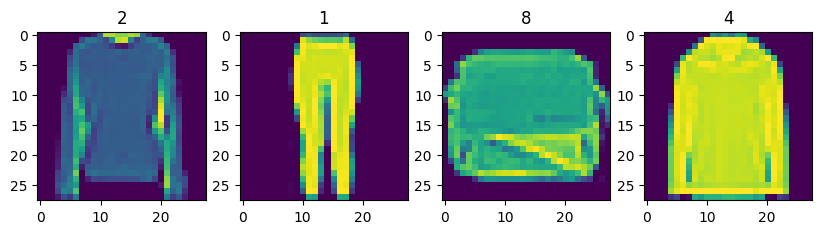

In [3]:
# visualizing data to get an idea

#set up the connection

datacon = data.as_numpy_iterator()

fig ,ax = plt.subplots(ncols=4,figsize=(10,10))

for idx in range(4):

  batch = datacon.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])


# 4.0 Preprocessing data

In [4]:
## Preprocessing data

#scale data

def image_scaler(data):
  image = tf.cast(data['image']/255,tf.float32)
  return image


In [5]:
# Reloaded data set
ds = tfds.load('fashion_mnist',split='train')
# Running data through the scaler funtion
ds = ds.map(image_scaler)
# cache the data set for that batch
ds = ds.cache()
# shuffel dataset
ds = ds.shuffle(60000)
# batch into 128 images per sample
ds = ds.batch(128)
# Reduce the likelihood of bottelnecking
ds = ds.prefetch(64)

# 5.0 Bulding the Nural Network

In [6]:

# Import squential api for generator and discriminator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Reshape,LeakyReLU,Dropout,UpSampling2D,Dense


In [7]:
# Bulid generator

def build_generator():

  model = Sequential()

  model.add(Dense(7*7*128,input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  #upsampling block1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  #upsampling block2

  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  #Convolutional block1

  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #Convolutional block2

  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #conv layer to get to one channel

  model.add(Conv2D(1,4,padding='same',activation='sigmoid'))




  return model

In [8]:
generator = build_generator()

In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 2s 2s/step


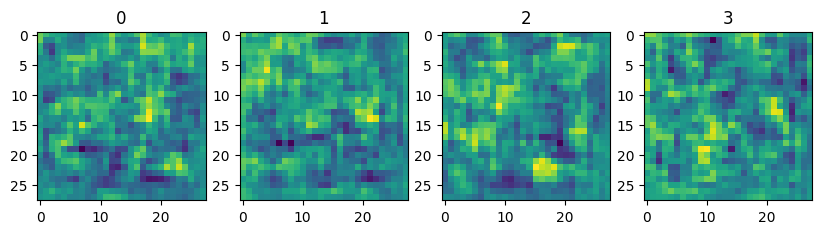

In [10]:
# visualizing randmly generated images

img = generator.predict(np.random.randn(4,128,1))


fig ,ax = plt.subplots(ncols=4,figsize=(10,10))

for idx,img in enumerate(img):


  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)




In [11]:
# Build Discriminator

def build_discriminator():

  # First conv block

  model = Sequential()

  # Conv block1
  model.add(Conv2D(32,5,input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv block2
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))


  # Conv block3
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv block4
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))



  # Flatten then pass to dense layer

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))



  return model

In [12]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

# 6.0 Construct Training Loop

In [13]:
# steup losses and optimizers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [14]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()


In [15]:
#Build subclassed model
#Importing the base model class to subclass our traning step
from tensorflow.keras.models import Model

In [16]:
class FashionGAN(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    super().__init__(*args,**kwargs)

    #create attribute for generator and discriminator

    self.generator =generator
    self.discriminator = discriminator


  def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    #compile with base class
    super().compile(*args,**kwargs)

    #create attribute for losses and optimizers

    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self,batch):
    #get the data

    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)),training=False)

    #tranin the discriminator

    with tf.GradientTape() as d_tape:

      #pass the real and fake images to discriminator
      yhat_real = self.discriminator(real_images,training=True)
      yhat_fake = self.discriminator(fake_images,training=True)
      yhat_reakfake = tf.concat([yhat_real,yhat_fake],axis=0)

      #create labels for real and fakes images
      y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

      #Add some noise to the TRUE outputs
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real,noise_fake],axis=0)

      #calculate loss -Binarycrossentropy
      total_d_loss = self.d_loss(y_realfake,yhat_reakfake)

    #apply backpropagation -- nn learn
    dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))


    #trian the generator

    with tf.GradientTape() as g_tape:

      # Generate new images
      gen_images = self.generator(tf.random.normal((128,128,1)),training=True)

      # Create the predicted labels
      predicted_labels = self.discriminator(gen_images,training=False)


      # Calculate loss -Binarycrossentropy
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)

    #apply backpropagation

    ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))




    return {'d_loss':total_d_loss,'g_loss':total_g_loss}


In [17]:
#create instance of subclass mode
fashgen = FashionGAN(generator,discriminator)

In [18]:
#compile the model
fashgen.compile(g_opt,d_opt,g_loss,d_loss)

In [19]:
#Build callback
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


In [20]:
class ModeMonitor(Callback):
  def __init__(self,num_img=3,latent_dim=128):
    self.num_img =num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self,epoch,logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img,self.latent_dim,1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images*=255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('/content/images',f'generated_img_{epoch}_{i}.png'))



In [26]:
# train the model

hist = fashgen.fit(ds,epochs=2000,callbacks=[ModeMonitor()])

Epoch 1/2000
469/469 [==============================] - 24s 51ms/step - d_loss: 0.6885 - g_loss: 0.6496
Epoch 2/2000
469/469 [==============================] - 24s 51ms/step - d_loss: 0.6455 - g_loss: 0.6090
Epoch 3/2000
469/469 [==============================] - 24s 51ms/step - d_loss: 0.6866 - g_loss: 0.6186
Epoch 4/2000
469/469 [==============================] - 24s 51ms/step - d_loss: 0.6855 - g_loss: 0.6207
Epoch 5/2000
469/469 [==============================] - 24s 51ms/step - d_loss: 0.6766 - g_loss: 0.6053
Epoch 6/2000
469/469 [==============================] - 24s 51ms/step - d_loss: 0.6830 - g_loss: 0.6112
Epoch 7/2000
469/469 [==============================] - 24s 51ms/step - d_loss: 0.6969 - g_loss: 0.6100
Epoch 8/2000
469/469 [==============================] - 24s 51ms/step - d_loss: 0.6886 - g_loss: 0.6366
Epoch 9/2000
469/469 [==============================] - 24s 51ms/step - d_loss: 0.6879 - g_loss: 0.6268
Epoch 10/2000
469/469 [==============================] - 24s 51m

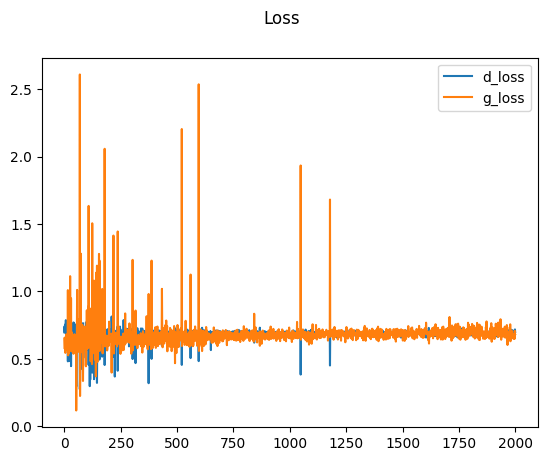

In [27]:
# Analyse Performance

plt.suptitle('Loss')
plt.plot(hist.history['d_loss'],label='d_loss')
plt.plot(hist.history['g_loss'],label='g_loss')
plt.legend()
plt.show()

## 7.0 Test the Generator

In [28]:

imgs = generator.predict(tf.random.normal((16,128,1)))

1/1 [==============================] - 0s 17ms/step


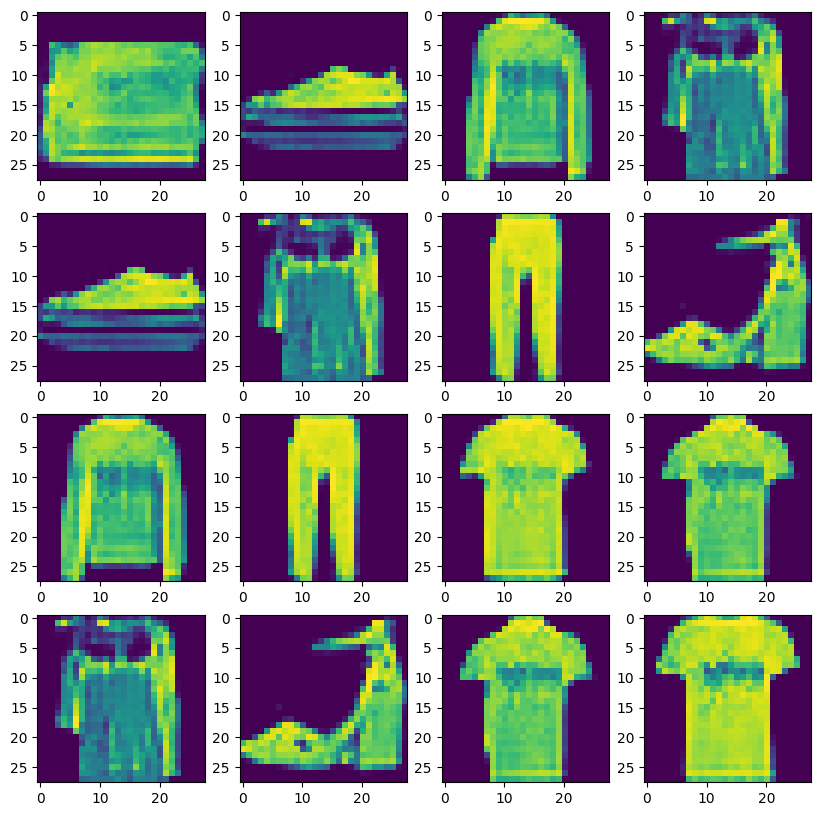

In [29]:
fig,ax = plt.subplots(ncols=4,nrows=4,figsize=(10,10))
for row in range(4):
    for col in range(4):
        ax[row][col].imshow(imgs[(row+1)*(col+1)-1])


In [30]:
# save the model
generator.save('generator.h5')
discriminator.save('discriminator.h5')